In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 📌 Создаем данные: рост, возраст → вес
X = np.array([
    [1.7, 25], [1.8, 30], [1.6, 20], [1.75, 35],
    [1.65, 40], [1.85, 45], [1.55, 18], [1.70, 29],
    [1.78, 33], [1.62, 21]
])
y = np.array([70, 80, 55, 78, 65, 90, 50, 74, 82, 58])

# 📌 Разделяем на train (80%) и validation (20%)
N = len(X)
split_idx = int(N * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# 📌 Нормализация данных (Standardization)
mean_X = np.mean(X_train, axis=0)
std_X = np.std(X_train, axis=0)
X_train = (X_train - mean_X) / std_X
X_val = (X_val - mean_X) / std_X

mean_y = np.mean(y_train)
std_y = np.std(y_train)
y_train = (y_train - mean_y) / std_y
y_val = (y_val - mean_y) / std_y

# 📌 Параметры обучения
learning_rate = 0.001
epochs = 5000  # Количество эпох
lambda_reg = 0.01  # Коэффициент L1-регуляризации (Lasso)
clip_value = 1.0  # Ограничение градиентов

# Лог для отслеживания процесса
losses = []
w1_history, w2_history, b_history = [], [], []

# 📌 Инициализируем случайные веса
w1, w2, b = np.random.randn(), np.random.randn(), np.random.randn()

In [3]:
# 🚨 Проверяем, что веса не NaN, иначе переопределяем
if np.isnan(w1) or np.isnan(w2) or np.isnan(b):
    print("Обнаружены NaN в весах! Переинициализируем...")
    w1, w2, b = np.random.randn(), np.random.randn(), np.random.randn()

# 📌 Adam: инициализация моментов
m_w1, m_w2, m_b = 0, 0, 0
v_w1, v_w2, v_b = 0, 0, 0
beta1, beta2, epsilon = 0.9, 0.999, 1e-8


### 📌 Функция потерь: Среднеквадратичная ошибка (MSE)

Функция потерь измеряет, насколько сильно предсказанные значения $\hat{y}$ отличаются от истинных $y$.  
Для линейной регрессии мы используем **среднеквадратичную ошибку (MSE)**:

$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

Где:
- $y_i$ — истинное значение,
- $\hat{y}_i$ — предсказанное значение модели,
- $n$ — количество примеров в обучающей выборке.

Чем **меньше** $MSE$, тем **лучше** работает модель!

In [4]:
def mse(y_true, y_pred):
    loss = np.mean((y_true - y_pred) ** 2)
    reg = lambda_reg * (abs(w1) + abs(w2))  # L1-регуляризация
    return loss + reg


### 📌 Градиентный спуск (Gradient Descent)

Градиентный спуск обновляет веса так, чтобы уменьшить ошибку. Формула для обновления:

$$ w := w - \eta \cdot \frac{\partial J(w)}{\partial w} $$

Где:
- $w$ — веса модели,
- $\eta$ — скорость обучения (**learning rate**),
- $\frac{\partial J(w)}{\partial w}$ — производная функции потерь $J(w)$ по $w$ (градиент).

В нашем случае, градиенты для весов считаются так:

$$ \frac{\partial J}{\partial w_1} = -\frac{2}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) x_{i1} $$

$$ \frac{\partial J}{\partial w_2} = -\frac{2}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) x_{i2} $$

$$ \frac{\partial J}{\partial b} = -\frac{2}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) $$

Эти градиенты мы используем для обновления весов во время обучения модели.

### 📌 Оптимизация: Momentum + L2-регуляризация

#### **Momentum**  
Метод Momentum ускоряет градиентный спуск, используя экспоненциальное сглаживание градиентов:

$$ v_t = \beta v_{t-1} + (1 - \beta) \frac{\partial J(w)}{\partial w} $$

$$ w_t = w_{t-1} - \eta v_t $$

Где:
- $v_t$ — экспоненциально сглаженный градиент,
- $\beta$ — коэффициент momentum (например, 0.9),
- $\eta$ — learning rate.

#### **L2-регуляризация (Ridge Regression)**  
Добавляет штраф за большие веса, чтобы предотвратить переобучение:

$$ J(w) = MSE + \lambda \sum w^2 $$

Где $\lambda$ — коэффициент регуляризации.

### 📌 Оптимизация: Adam Optimizer

Adam — это адаптивный метод оптимизации, который учитывает моменты градиента.

**1. Вычисляем моменты:**
$$ m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t $$
$$ v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 $$

**2. Корректируем смещения:**
$$ \hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t} $$

**3. Обновляем веса:**
$$ w_t = w_{t-1} - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \cdot \hat{m}_t $$

Где:
- $\beta_1 = 0.9, \beta_2 = 0.999$ — коэффициенты экспоненциального сглаживания,
- $\epsilon = 10^{-8}$ — предотвращает деление на 0.

In [9]:
# 📌 Запуск обучения
for epoch in range(1, epochs + 1):
    # 1️⃣ Предсказание значений
    y_pred = w1 * X_train[:, 0] + w2 * X_train[:, 1] + b
    
    # 2️⃣ Вычисляем MSE-ошибку и сохраняем ее
    loss = mse(y_train, y_pred)
    losses.append(loss)

    # 3️⃣ Логируем веса для последующей визуализации
    w1_history.append(w1)
    w2_history.append(w2)
    b_history.append(b)

    # 4️⃣ Вычисляем градиенты функции потерь с учетом L1-регуляризации
    # L1-регуляризация добавляет штраф (lambda_reg * sign(w)) к градиенту
    dw1 = -2 * np.mean((y_train - y_pred) * X_train[:, 0]) + lambda_reg * np.sign(w1)
    dw2 = -2 * np.mean((y_train - y_pred) * X_train[:, 1]) + lambda_reg * np.sign(w2)
    db = -2 * np.mean(y_train - y_pred)

    # 5️⃣ Градиентный клиппинг — ограничиваем величину градиента, чтобы избежать нестабильности
    dw1, dw2, db = np.clip(dw1, -clip_value, clip_value), np.clip(dw2, -clip_value, clip_value), np.clip(db, -clip_value, clip_value)

    # 6️⃣ Вычисляем первые моменты (m) с экспоненциальным сглаживанием (β1)
    # Это "ускоряет" градиентный спуск и уменьшает влияние шумовых градиентов
    m_w1 = beta1 * m_w1 + (1 - beta1) * dw1
    m_w2 = beta1 * m_w2 + (1 - beta1) * dw2
    m_b = beta1 * m_b + (1 - beta1) * db

    # 7️⃣ Вычисляем вторые моменты (v) — это усредненные квадраты градиентов (β2)
    # Они помогают регулировать размер шага в зависимости от величины градиента
    v_w1 = beta2 * v_w1 + (1 - beta2) * (dw1 ** 2)
    v_w2 = beta2 * v_w2 + (1 - beta2) * (dw2 ** 2)
    v_b = beta2 * v_b + (1 - beta2) * (db ** 2)

    # 8️⃣ Коррекция смещения для моментов (иначе в начале обучения они могут давать неточные обновления)
    m_w1_hat, m_w2_hat, m_b_hat = m_w1 / (1 - beta1 ** epoch), m_w2 / (1 - beta1 ** epoch), m_b / (1 - beta1 ** epoch)
    v_w1_hat, v_w2_hat, v_b_hat = v_w1 / (1 - beta2 ** epoch), v_w2 / (1 - beta2 ** epoch), v_b / (1 - beta2 ** epoch)

    # 9️⃣ Обновление весов с учетом скорректированных моментов
    # - Делим на sqrt(v) + epsilon, чтобы избежать деления на 0
    # - Это ключевая формула Adam-оптимизатора
    w1 -= learning_rate * m_w1_hat / (np.sqrt(v_w1_hat) + epsilon)
    w2 -= learning_rate * m_w2_hat / (np.sqrt(v_w2_hat) + epsilon)
    b -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

    # 🔟 Логируем метрику каждые 100 эпох
    if epoch % 100 == 0:
        print(f"Эпоха {epoch}, Ошибка: {loss:.3f}, w1={w1:.5f}, w2={w2:.5f}, b={b:.5f}")


Эпоха 100, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 200, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 300, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 400, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 500, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 600, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 700, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 800, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 900, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 1000, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 1100, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 1200, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 1300, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 1400, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 1500, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 1600, Ошибка: 0.031, w1=0.89774, w2=0.11463, b=-0.00000
Эпоха 1700, Ошибк

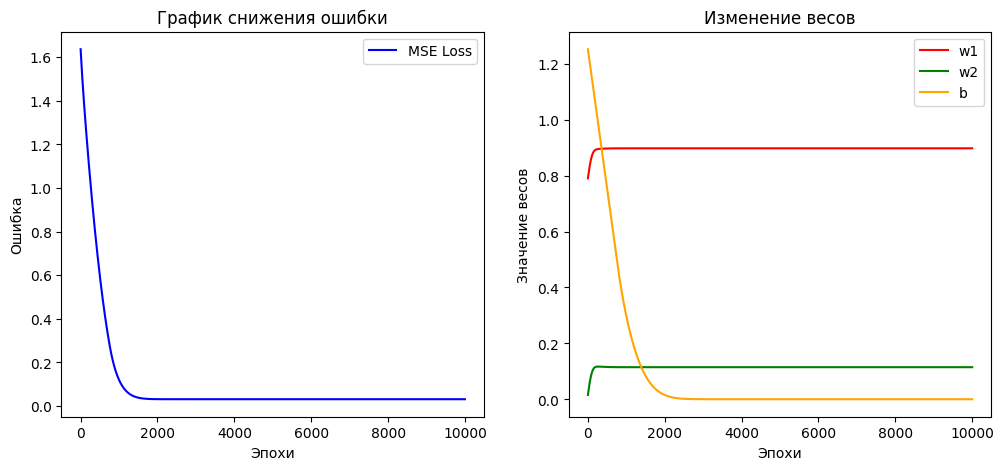

In [10]:
# 📌 Визуализация результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label='MSE Loss', color='blue')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.title('График снижения ошибки')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(w1_history, label='w1', color='red')
plt.plot(w2_history, label='w2', color='green')
plt.plot(b_history, label='b', color='orange')
plt.xlabel('Эпохи')
plt.ylabel('Значение весов')
plt.title('Изменение весов')
plt.legend()

plt.show()

In [11]:
# 📌 Оценка модели на тестовых данных
y_val_pred = w1 * X_val[:, 0] + w2 * X_val[:, 1] + b
val_loss = mse(y_val, y_val_pred)
print(f"📊 Ошибка на валидационных данных (MSE): {val_loss:.3f}")

📊 Ошибка на валидационных данных (MSE): 0.026


In [12]:
# 📌 Тестируем модель на новых данных
рост = 1.72
возраст = 28
X_new = np.array([[рост, возраст]])
X_new = (X_new - mean_X) / std_X
предсказанный_вес_norm = w1 * X_new[0, 0] + w2 * X_new[0, 1] + b
предсказанный_вес = (предсказанный_вес_norm * std_y) + mean_y

print(f"🔮 Предсказанный вес для роста {рост}м и возраста {возраст} лет: {предсказанный_вес:.2f} кг")


🔮 Предсказанный вес для роста 1.72м и возраста 28 лет: 72.27 кг
